In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [3]:
def lin_ccc(y_true, y_pred):
    rho = np.corrcoef(y_true, y_pred)[0, 1]
    mu_x = np.mean(y_pred)
    mu_y = np.mean(y_true)
    sigma_x = np.std(y_pred)
    sigma_y = np.std(y_true)
    ccc = (2 * rho * sigma_x * sigma_y) / (sigma_x**2 + sigma_y**2 + (mu_x - mu_y)**2)
    return ccc

In [4]:
# 读取Excel文件
file_path = 'D:\\桌面\\2025.1\\英文\\split_data1.xlsx'
xls = pd.ExcelFile(file_path)

# 获取最后一个sheet的名称
last_sheet_name = xls.sheet_names[-1]

# 读取最后一个sheet的数据
df = pd.read_excel(xls, sheet_name=last_sheet_name)

# 去除非数值列
df_numeric = df.select_dtypes(include=[float, int])

# 检查数据框是否为空
if df_numeric.empty:
    print(f"Sheet: {last_sheet_name} is empty or contains no numeric data.")
else:
    # 分离特征和目标变量
    X = df_numeric.iloc[:, :-1]  # 所有行，除了最后一列
    y = df_numeric.iloc[:, -1]   # 最后一列

    # 检查最后一列是否为空
    if y.empty:
        print(f"Sheet: {last_sheet_name} has no target variable.")
    else:
        # 检查是否有NaN值
        if X.isnull().values.any() or y.isnull().values.any():
            # 使用SimpleImputer填充NaN值
            imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
            X = imputer.fit_transform(X)
            y = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

        # 划分训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
# 初始化GBDT回归器
gbdt_reg = GradientBoostingRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)

# 训练GBDT模型
gbdt_reg.fit(X_train, y_train)
y_pred_gbdt = gbdt_reg.predict(X_test)

# 计算GBDT模型的评估指标
r2_gbdt = r2_score(y_test, y_pred_gbdt)
mse_gbdt = mean_squared_error(y_test, y_pred_gbdt)
rmse_gbdt = np.sqrt(mse_gbdt)
ccc_gbdt = lin_ccc(y_test, y_pred_gbdt)

# 输出GBDT模型的评估指标
print(f"GBDT - R²: {r2_gbdt:.4f}, MSE: {mse_gbdt:.4f}, RMSE: {rmse_gbdt:.4f}, LCCC: {ccc_gbdt:.4f}")

GBDT - R²: 0.2184, MSE: 77.9675, RMSE: 8.8299, LCCC: 0.3791


In [6]:
# 使用statsmodels进行多元线性回归
X_train_sm = sm.add_constant(X_train)  # 添加常数项
model = sm.OLS(y_train, X_train_sm).fit()
y_pred_lr = model.predict(sm.add_constant(X_test))

# 计算多元线性回归模型的评估指标
r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
ccc_lr = lin_ccc(y_test, y_pred_lr)

# 输出多元线性回归的统计检验结果
print(f"Sheet: {last_sheet_name}")
print(model.summary())

# 输出多元线性回归模型的评估指标
print(f"Linear Regression - R²: {r2_lr:.4f}, MSE: {mse_lr:.4f}, RMSE: {rmse_lr:.4f}, LCCC: {ccc_lr:.4f}")

Sheet: 2013
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     3.849
Date:                Mon, 27 Jan 2025   Prob (F-statistic):           2.24e-05
Time:                        19:39:47   Log-Likelihood:                -2179.2
No. Observations:                 593   AIC:                             4382.
Df Residuals:                     581   BIC:                             4435.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9412      0.740      1.

Correlation matrix:
                                            Life Expectancy  \
Life Expectancy                                    1.000000   
Childhood Obesity                                  0.490218   
Incapacity Benefit rate                            0.564460   
Unemployment rate                                  0.602725   
 Crime Index                                       0.365413   
Deliberate Fires                                   0.403126   
Average GCSE Score                                 0.499855   
Absence Rate (%)                                   0.499260   
Dependent children in out-of-work families         0.672037   
Public Transport Accessibility                    -0.086381   
Green Space Percentage                             0.055400   
Subjective well-being                             -0.080386   

                                            Childhood Obesity  \
Life Expectancy                                      0.490218   
Childhood Obesity             

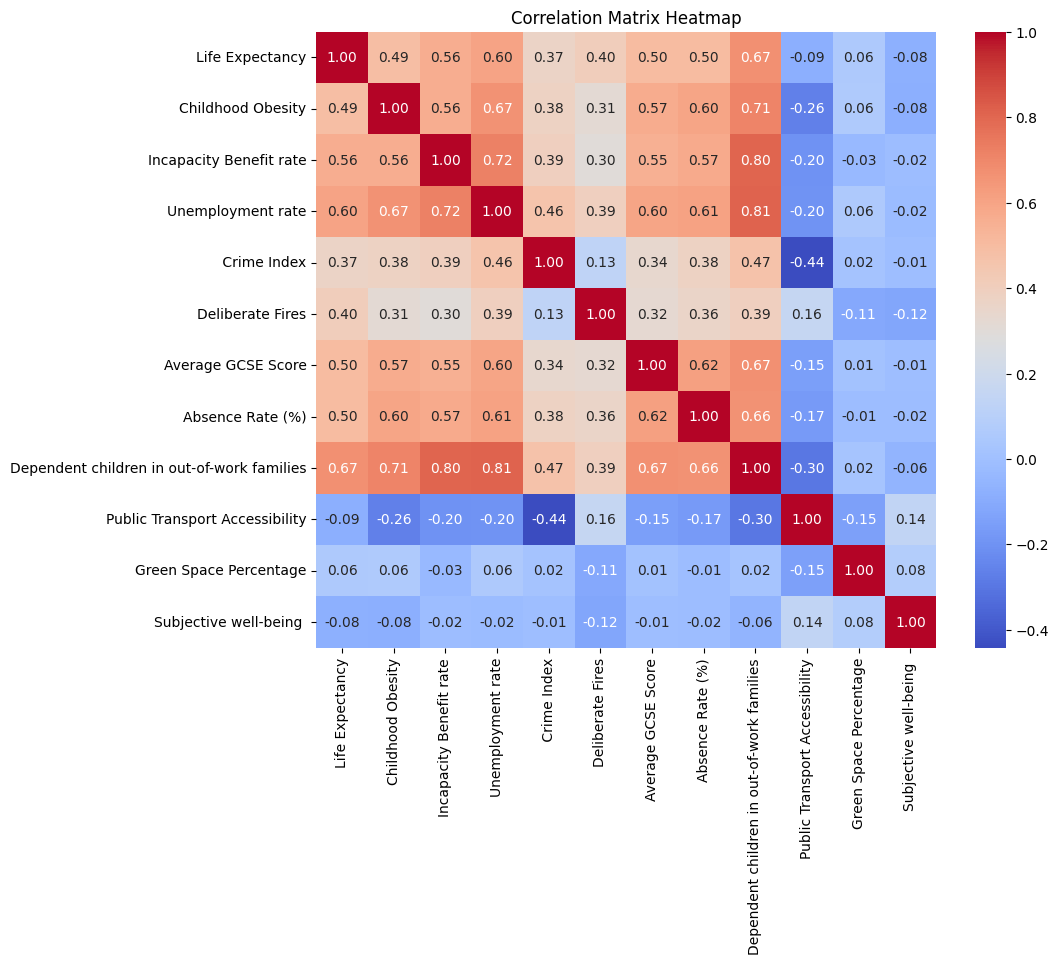

In [7]:
# 各自变量之间的相关性检验
corr_matrix = df_numeric.corr()
print("Correlation matrix:")
print(corr_matrix)

# 绘制相关性热力图
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

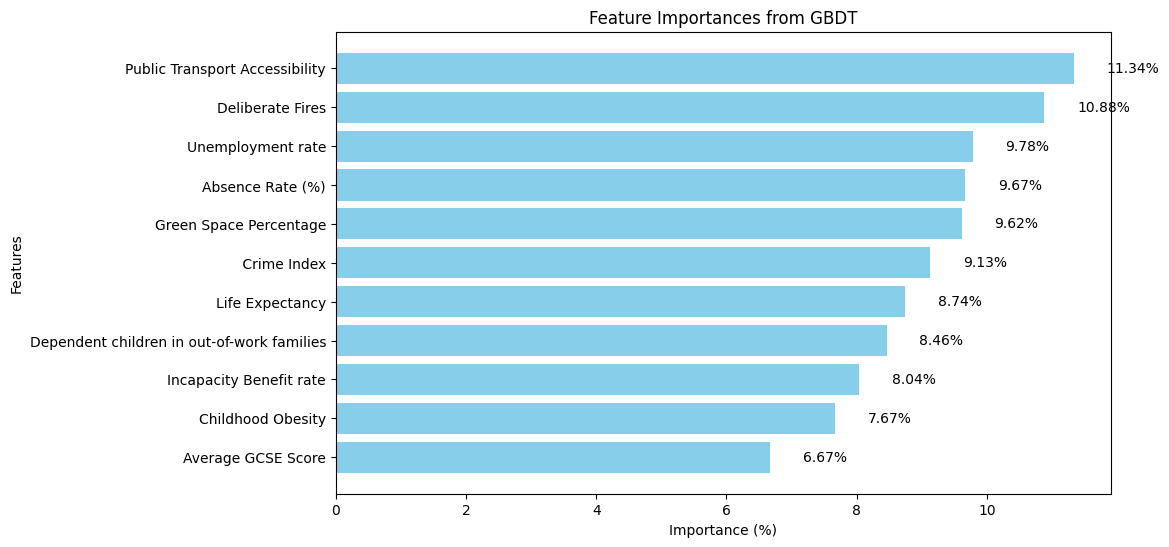

In [8]:
# GBDT出图
feature_importances = gbdt_reg.feature_importances_
features = df_numeric.columns[:-1]

# 创建一个DataFrame来存储特征重要性
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# 将重要性转换为百分比
importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum() * 100

# 按重要性排序
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 绘制条形图
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance (%)')
plt.ylabel('Features')
plt.title('Feature Importances from GBDT')
plt.gca().invert_yaxis()  # 使最重要的特征在顶部
for i, v in enumerate(importance_df['Importance']):
    plt.text(v + 0.5, i, f"{v:.2f}%", color='black', va='center')
plt.show()

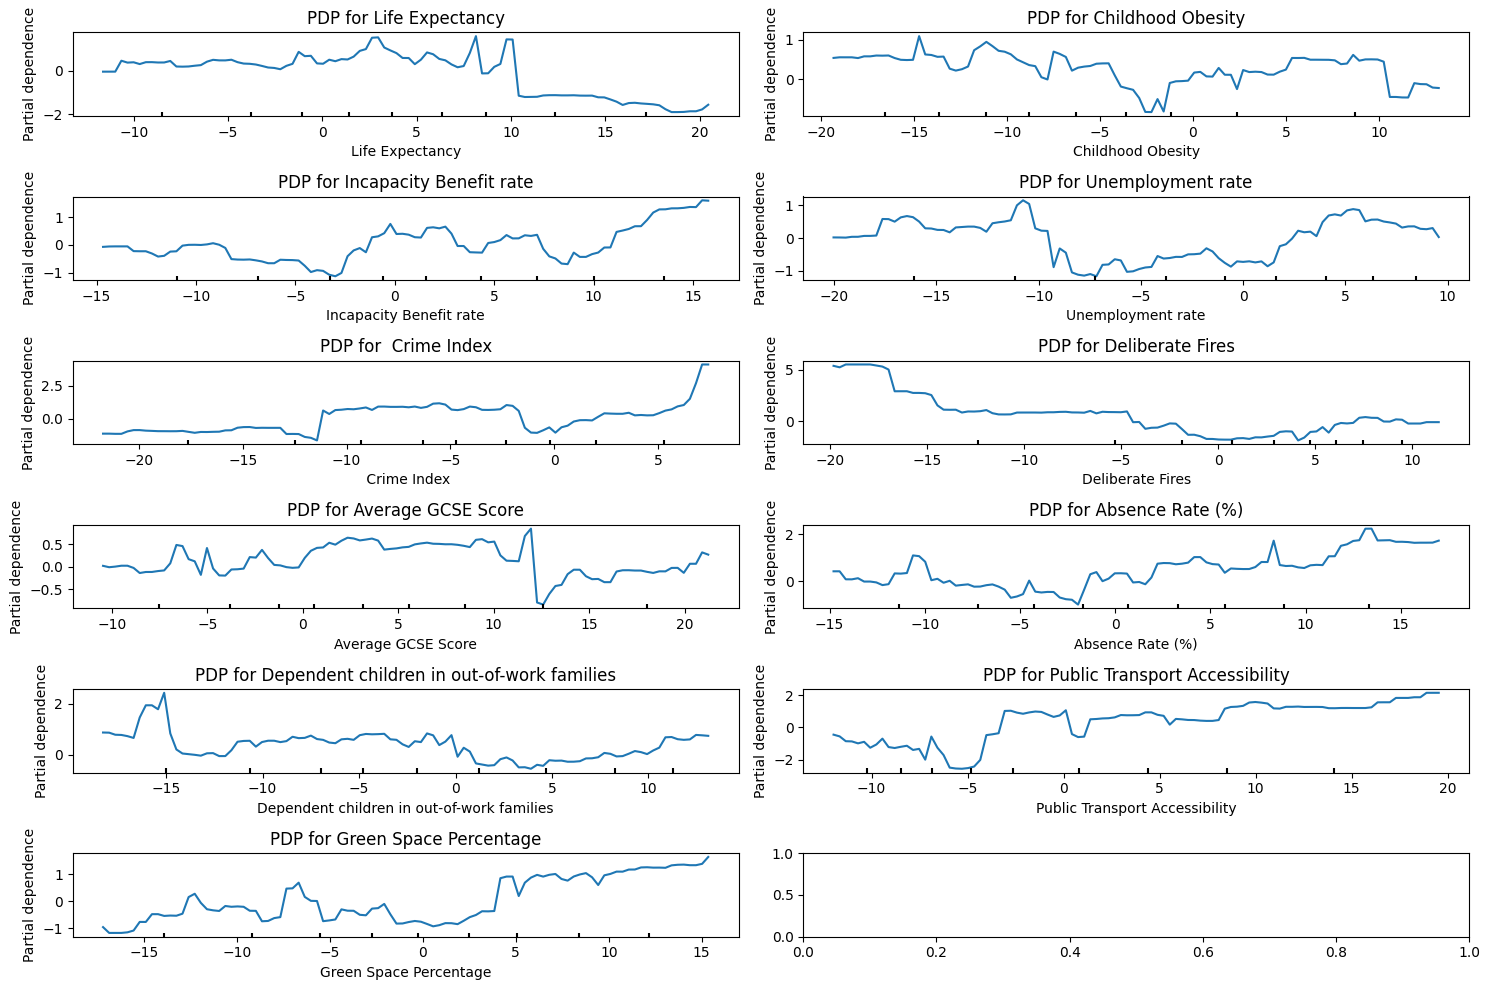

In [10]:
from sklearn.inspection import PartialDependenceDisplay

# 绘制每个特征的部分依赖图
features = df_numeric.columns[:-1]
fig, ax = plt.subplots(nrows=(len(features) + 1) // 2, ncols=2, figsize=(15, 10))
ax = ax.ravel()  # 将ax数组展平

for i, feature in enumerate(features):
    # 确保特征索引在有效范围内
    feature_index = list(df_numeric.columns).index(feature)
    display = PartialDependenceDisplay.from_estimator(
        gbdt_reg,
        X_train,
        features=[feature_index],
        ax=ax[i],
        feature_names=list(df_numeric.columns),
        target=0
    )
    ax[i].set_title(f'PDP for {feature}')

plt.tight_layout()
# 保存图片并设置DPI为600
plt.savefig('partial_dependence_plot.png', dpi=600)
# 注释掉下面这行，避免重复显示
plt.show()

In [26]:
import pandas as pd

# 读取Excel文件
file_path = '统计性分析.xlsx'
df = pd.read_excel(file_path)

# 去除最后一列，获取其余变量
features = df.columns[:-1]
df_features = df[features]

# 计算描述性统计
features_stats = df_features.describe()

# 打印描述性统计
print("Descriptive statistics for features:")
print(features_stats)

Descriptive statistics for features:
       Life Expectancy  Childhood Obesity  Incapacity Benefit rate  \
count       658.000000         657.000000               658.000000   
mean         81.993009          21.566959                 1.730851   
std           2.223901           4.956378                 0.666191   
min          76.000000           6.224066                 0.100000   
25%          80.400000          18.658892                 1.225000   
50%          81.900000          22.173382                 1.700000   
75%          83.400000          25.278810                 2.100000   
max          90.300000          35.714286                 4.800000   

       Unemployment rate   Crime Index  Deliberate Fires  Average GCSE Score  \
count         658.000000    658.000000        658.000000          658.000000   
mean            5.969605     82.346657          0.480243          349.565420   
std             3.311792     29.394091          0.428340           17.456376   
min         